In [1]:
### Implement TD control to solve OpenAI's Taxi problem using gym.

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import sys

In [3]:
env_name = "Taxi-v3"
env = gym.make(env_name)

In [4]:
env = env.unwrapped #gets ride of TimeLimit

In [5]:
class Agent():
    """
    This class is used in finding/converging towards the optimal policy for Taxi-lab environment in OpenAI.
    User can select between either of the 3 TD control methods, i.e. sarsa, sarsa_max (Q), or expected_sarsa.
    
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
        
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east 
    - 3: move west 
    - 4: pickup passenger
    - 5: dropoff passenger
    
    -----
    Read individual method docstring for more info.
    Resources:
    1. Taxi Environment paper: https://arxiv.org/pdf/cs/9905014.pdf
    2. OpenAI simulation: https://gym.openai.com/envs/Taxi-v3
    -----
    Author: Qasim Wani
    Date written: July 18, 2020.
    """
    def __init__(self, env):
        self.nA = env.action_space.n
        self.Q = defaultdict(lambda : np.zeros(self.nA))
        self.env = env
        
    def encode(self, row, col, loc, dest):
        """
        Given a tuple of observation consisting of taxi's position (row, column)
        with the passengers current location and point of destination, encode it
        into an integer of range: (0, 500].
        @Param:
        1. row: Taxi row number: (int) 0 - 4
        2. col: Taxi column number: (int) 0 - 4
        3. loc: passenger location: one of the 4 colors, Red, Green, Blue, Yellow, or in-taxi (full)
        4. dest: passenger destination: one of the 4 corners in the grid indicated as: R/G/B/Y
        @Returns:
        - i: encoded number given the observational state of the environment, env.
        Credits: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py#L130
        """
        i = row
        i *= 5
        i += col
        i *= 5
        i += loc
        i *= 4
        i += dest
        return i
    
    def decode(self, i):
        """
        Given an integer (0, 500], decode it into the following:
        1. taxi row.
        2. taxi column.
        3. passenger location.
        4. passenger destination.
        Credits: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py#L141
        """
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        return tuple(reversed(out))
    
    def initialize_env(self, decode=True):
        """
        Initializes the environment, randomly, and decodes the observational state using decode() f(x).
        Uses env.reset() internally.
        Return the observational state as a decoded version if decode is set to true (default)
        Otherwise, returns the encoded state version.
        """
        return self.decode(self.env.reset()) if decode else self.env.reset()
    
    def generate_episode(self, values, TD_type = "sarsa"):
        """
        Generates an episode & updates the Q_table along the way.
        Parameters:
        1. values: tuple of gamma, alpha, & epsilon values.
        2. TD_type: type of TD control to use. default = 'sarsa'. Options: "sarsa", "Q", "expected_sarsa".
        Returns:
        - Q : Updated Q table.
        - steps_to_completion: #steps it took to complete an episode.
        - total_reward: total reward accumulated during the episode.
        """
        state = self.initialize_env(decode = False) #initial state, decoded
        gamma, alpha, epsilon = values #extract information
        nA = self.nA #action space size.
        steps_to_completion:int = 0 #number of steps taken to task completion in one episode
        total_reward:int = 0 #total reward accumulated in an episode
        Q = self.Q
        while True:
            action = self.get_action(Q, state, epsilon)#choose between greedy or equiprobable action

            next_state, reward, done,_ = self.env.step(action) #step into the episode
            value = Q[state][action] #get current value
            next_action = self.get_action(Q, next_state, epsilon)#choose between greedy/random for next state

            # Choose b/w 3 TD control algorithms.
            #SARSA: Q(S0, A0) --> Q(S0, A0) + å(R1 + gamma(Q(S1, A1) - Q(S0, A0)))
            #SARSA Max: Q(S0, A0) --> Q(S0, A0) + å(R1 + gamma(max (Q(S1, a)) - Q(S0, A0)))
            #Expected SARSA: Q(S0, A0) --> Q(S0, A0) + å(R1 + gamma(Σ[ π(a | S1)* Q(S1, a) ] - Q(S0, A0)))

            target = self.get_value_TD(next_state, next_action, TD_type, epsilon) #choice of TD
            value += alpha*(reward + gamma*(target - value))
            Q[state][action] = value #update Q-table
                
            state = next_state #update state
            steps_to_completion += 1 #increment number of steps to episode completion
            total_reward += reward #increment reward counter
            if(done): #episode completed
                break
        return Q, steps_to_completion, total_reward

    def get_action(self, Q, state, eps):
        """
        Gets the action following epsilon greedy policy.
        Parameters:
        1. Q: Q-table.
        2. state: current state in the episode.
        3. eps: epsilon value following GLIE conditions.
        Returns:
        - actions: the action to take based on choosing greedy action or random action
        """
        #exploit if True else explore
        return np.argmax(Q[state]) if np.random.random() > eps else np.random.choice(np.arange(self.nA))
    
    def get_value_TD(self, next_state, next_action = None, TD_type = "sarsa", epsilon = None):
        """
        Returns the value from the Q table based on the type of TD control algorithm
        @Param:
        1. next_state: S_(t+1) from the episode
        2. next_action: A_(t+1). None if TD_type ≠ 'sarsa'
        3. TD_type: type of TD control algorithm to use. Can be 'sarsa', 'Q', or 'expected_sarsa'
        4. epsilon: value for epsilon.
        Returns:
        - value: value from the Q-table based on the Temporal Difference control algorithm used.
        """
        Q = self.Q #retrieve the current Q table
        if(TD_type == "sarsa"):
            return Q[next_state][next_action] if next_action is not None else 0
        elif(TD_type == "Q"):
            return np.max(Q[next_state])
        elif(TD_type == "expected_sarsa"):
            policy_s = np.ones(self.nA) * epsilon / self.nA
            policy_s[np.argmax(Q[next_state])] = 1 - epsilon + (epsilon / self.nA)
            return np.dot(Q[next_state], policy_s)
        else:
            raise ValueError("Invalid TD_type specified")

In [6]:
def TD_learning(agent, num_episodes, alpha, gamma=1.0, td_type = "sarsa"):
    """
    Runs the optimal TD (specified in params) operation and returns the optimal policy and Q table.
    Utlizes the agent class created previously.
    @Params:
    1. agent: Instance of agent class.
    2. num_episodes: number of episodes to train for.
    3. alpha: value of alpha for regularizer.
    4. gamma: discounted return, Ɣ (refer to Bellman Equations)
    5. td_type: type of TD control. Choose str between 'sarsa', 'Q', or 'expected_sarsa'
    @Returns:
    1. Q - estimated optimal Q table.
    2. policy - estimated optimal policy, π.
    """
    # initialize performance monitor
    steps_arr = []
    reward_arr = []
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## Q-learning implementation

        epsilon = 1.0/i_episode #impose GLIE conditions
        Q_updated, steps, reward = agent.generate_episode((gamma, alpha, epsilon), TD_type = td_type)
        Q = Q_updated #update value for Q-table
        #performance monitor
        steps_arr.append(steps)#append #steps for current episode (should decrease as num_episode -> ∞)
        reward_arr.append(reward)#should approach optimal reward as num_episode -> ∞
    
    #convert performance metrics to nd.array
    steps_arr = np.array(steps_arr)
    reward_arr = np.array(reward_arr)
    plt.plot(steps_arr, label="steps")#plot steps
    plt.plot(reward_arr, label="reward")#plot reward
    plt.xlabel("Number of episodes")
    plt.ylabel("Continuous value")
    plt.ylim(-300, 300)#set y-axis boundaries
    plt.legend(loc="upper right")#display legend
    plt.show()
    
    print("SUMMARY")
    print(f"\nAverage Reward: {reward_arr.mean()}\nAverage Steps to completion: {steps_arr.mean()}")
    print("\n*******BEFORE*******")
    print(f"\nMinimum Reward attained at the end of an episode: {reward_arr.min()} at pos: {reward_arr.argmin()}")
    print(f"Greatest number of steps for an episode: {steps_arr.max()} at position: {steps_arr.argmax()}")
    print("\n*******AFTER*******")
    print(f"Maximum Reward attained at an episode: {reward_arr.max()} at position #: {reward_arr.argmax()}")
    print(f"Fewest number of steps took for task completion: {steps_arr.min()} at pos: {steps_arr.argmin()}")
    
    ### Find the optimal policy, π*
    policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(500)]).reshape((5, 5, 5, 4))
    return Q, policy

In [7]:
agent = Agent(env)

In [8]:
agent.env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Episode 50000/50000

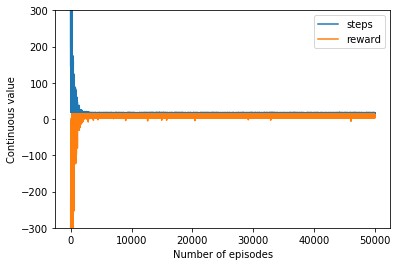

SUMMARY

Average Reward: 5.75338
Average Steps to completion: 14.49656

*******BEFORE*******

Minimum Reward attained at the end of an episode: -4803 at pos: 0
Greatest number of steps for an episode: 1534 at position: 4

*******AFTER*******
Maximum Reward attained at an episode: 15 at position #: 178
Fewest number of steps took for task completion: 6 at pos: 178


In [9]:
# obtain the estimated optimal policy and corresponding action-value function
Q_optimal, policy_optimal = TD_learning(agent, 50000, 0.1, td_type="Q")

In [10]:
def run_optimal_policy(agent, Q_optimal, num_episodes, td_type = 'sarsa', epsilon=0.0, gamma=1.0, alpha=1.0):
    """
    Runs the optimal policy for an agent.
    @Params:
    1. agent: Instance of Agent class.
    2. Q_optimal: optimal Q-table (must be trained above)
    3. num_episodes: number of episodes to test Q-table for.
    4. td_type: TD control type. By default, 'sarsa'
    5. epsilon: rate of exploration (used in greedy policy) hyper-parameter.
    6. gamma: discounted return regularizer hyper-parameter.
    7. alpha: control predictive regularizer hyper-parameter.
    @Returns:
    1. average_reward at the end of running num_episodes.
    2. average_steps for completion.
    3. matplotlib.pyplot chart for reward (pprint only)
    """
#     agent.Q = Q_optimal
    values = (gamma, alpha, epsilon)
    steps_arr = [] #initialize steps counter
    reward_arr = [] #initializer reward counter
    for i in range(1, num_episodes + 1):
        # monitor progress
        if i % 100 == 0:
            print("\rEpisode {}/{}".format(i, num_episodes), end="")
            sys.stdout.flush()
        
        _, steps, reward = agent.generate_episode(values, TD_type = td_type)
        #performance monitor
        steps_arr.append(steps)#append #steps for current episode (should decrease as num_episode -> ∞)
        reward_arr.append(reward)#should approach optimal reward as num_episode -> ∞
    
    #convert performance metrics to nd.array
    steps_arr = np.array(steps_arr)
    reward_arr = np.array(reward_arr)
    plt.plot(steps_arr, label="steps")#plot steps
    plt.plot(reward_arr, label="reward")#plot reward
    plt.xlabel("Number of episodes")
    plt.ylabel("Continuous value")
    plt.ylim(-30, 20)#set y-axis boundaries
    plt.legend(loc="upper right")#display legend
    plt.show()
    
    return reward_arr, steps_arr

Episode 1000/1000

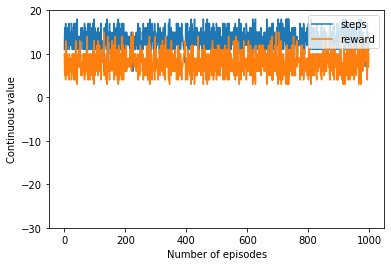

In [11]:
reward_optimal, steps_optimal = run_optimal_policy(agent, Q_optimal, 1000, td_type="Q")

In [12]:
reward_optimal.mean(), steps_optimal.mean()

(7.901, 13.099)

In [13]:
reward_optimal.max()

15